In [1]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.QED import qed
from tqdm import tqdm
import collections



# GuacaMol uncond generation

In [2]:
with open("../guacamol_correct_ldm_vae_10000_smiles.pkl", "rb") as f:
    vae_uncon_data = pickle.load(f)
with open("../guacamol_correct_ldm_aae_10000_smiles.pkl", "rb") as f:
    aae_uncon_data = pickle.load(f)
with open("../guacamol_correct_ldm_wae_10000_smiles.pkl", "rb") as f:
    wae_uncon_data = pickle.load(f)

In [13]:
len(vae_uncon_data)

10000

In [14]:
training_set = pd.read_csv("/data/ongh0068/guacamol/guacamol_v1_all.smiles", header=None)
training_set.values

array([['CCCC(=O)NNC(=O)Nc1ccccc1'],
       ['CC(=O)NC1CCC2(C)C(CCC3(C)C2C(=O)C=C2C4C(C)C(C)CCC4(C)CCC23C)C1(C)C(=O)O'],
       ['CC(=O)NC(C)Cc1ccc(C#Cc2ccnc(N3CCCC(F)C3)n2)cc1'],
       ...,
       ['NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1'],
       ['COc1ccc(C2C(C#N)=C(N=CN3CCN(C)CC3)OC3=C2C(=O)CC(C)(C)C3)cc1'],
       ['O=C(CC(NC(=O)c1ccccc1)c1ccccc1)Oc1ccc([N+](=O)[O-])cc1']],
      dtype=object)

In [15]:
training_set1 = np.reshape(training_set.values, (-1))
training_set1

array(['CCCC(=O)NNC(=O)Nc1ccccc1',
       'CC(=O)NC1CCC2(C)C(CCC3(C)C2C(=O)C=C2C4C(C)C(C)CCC4(C)CCC23C)C1(C)C(=O)O',
       'CC(=O)NC(C)Cc1ccc(C#Cc2ccnc(N3CCCC(F)C3)n2)cc1', ...,
       'NCCCC(=O)Nc1ccc(C(=O)Nc2nccs2)cc1',
       'COc1ccc(C2C(C#N)=C(N=CN3CCN(C)CC3)OC3=C2C(=O)CC(C)(C)C3)cc1',
       'O=C(CC(NC(=O)c1ccccc1)c1ccccc1)Oc1ccc([N+](=O)[O-])cc1'],
      dtype=object)

In [16]:
ori_data = np.random.choice(training_set1, 10000)
ori_data

array(['COc1cc(C2CC(n3nnc(COc4c(-c5ccc(C)cc5)oc5ccccc5c4=O)c3I)CC(c3ccccc3)O2)cc(OC)c1OC',
       'CCOC(=O)C=CC(=O)OCC(=O)Nc1ccc(Cl)cc1Cl',
       'Cc1ccc(N(CCN2CCC(OCC(=O)O)CC2)C(=O)c2ccc3c(c2)OCO3)cc1', ...,
       'O=[N+]([O-])OC(CO)CO',
       'COCc1ccc(CNC(=O)c2c(-c3ccccc3)c(-c3ccc(F)cc3)c(CCC(O)CC(O)CC(=O)O)n2C(C)C)cc1',
       'CC(C)CC1NC(=O)C(C)NC(=O)CNC(=O)C2CCCN2C(C(=O)NC(C)(C)C)C(C)NC(=O)C(CCCCN)NC1=O'],
      dtype=object)

In [17]:
ori_data.shape

(10000,)

## SA Score

In [11]:
def smiles2mol(data):
    return [Chem.MolFromSmiles(smile) for smile in data]

In [19]:
guacamol_mols = {
    "ldm_vae": smiles2mol(vae_uncon_data),
    "ldm_aae": smiles2mol(aae_uncon_data),
    "ldm_wae": smiles2mol(wae_uncon_data),
    "original_data": smiles2mol(ori_data)
}

In [13]:
def compute_sa_score(mols, threshold = 4.5):
    
    sa_scores = [sascorer.calculateScore(mol) for mol in mols]
    pct_easily_synthesized = len([score for score in sa_scores if score <=4.5])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

In [21]:
saqed=dict()

for file in guacamol_mols.keys():
#     mols = [Chem.MolFromSmiles(smile) for smile in file_to_smiles[file]]
    mols = guacamol_mols[file]
    
    qed_scores = [qed(mol) for mol in mols]
    sa_scores, pct_easily_synthesized = compute_sa_score(mols)
    saqed[file] = {}
    saqed[file]['sa_scores'] = sa_scores
    saqed[file]['pct_easily_synthesized'] = pct_easily_synthesized
    
    saqed[file]['qed_scores'] = qed_scores

In [22]:
tmp = saqed
dfs = []
for key in tmp:
    sa_scores = tmp[key]['sa_scores']
    qed_scores = tmp[key]['qed_scores']
    dist_type = [key for _ in range(len(tmp[key]['sa_scores']))]
    df = pd.DataFrame([sa_scores, qed_scores, dist_type]).T
    df.columns = ['sa_score', 'qed_scores', 'dist_type']
    
    dfs.append(df)

In [23]:
guac_saqed = pd.concat(dfs)
guac_saqed

,sa_score,qed_scores,dist_type
0,1.0,0.458806,ldm_vae
1,1.722314,0.467256,ldm_vae
2,1.741554,0.613662,ldm_vae
3,2.186266,0.501336,ldm_vae
4,1.647896,0.538183,ldm_vae
...,...,...,...
9995,2.985094,0.512972,original_data
9996,2.160913,0.513178,original_data
9997,3.105511,0.364868,original_data
9998,3.511607,0.127425,original_data


Text(0.5, 1.0, 'Non-gene expression conditioned Synthetic Accesibility')

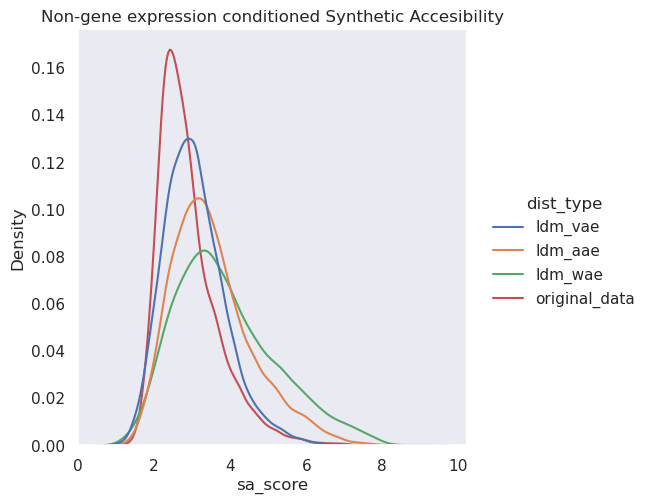

In [49]:
sns.set_theme()
sns.set_style("dark")
sns.displot(guac_saqed ,x = 'sa_score',  hue="dist_type", kind = 'kde')
plt.title('Non-gene expression conditioned Synthetic Accesibility')

Text(0.5, 1.0, 'Non-gene expression conditioned Synthetic Accesibility')

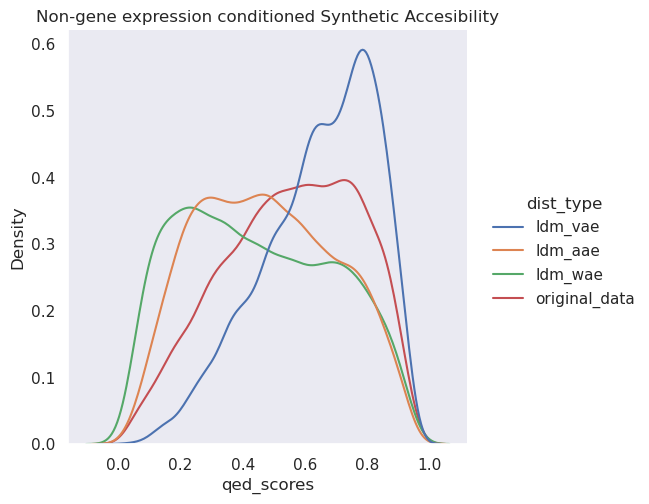

In [50]:
sns.set_theme()
sns.set_style("dark")
sns.displot(guac_saqed ,x = 'qed_scores',  hue="dist_type", kind = 'kde')
plt.title('Non-gene expression conditioned Synthetic Accesibility')

In [24]:
pct_easily_syn_non_conditioned = {}
for dist_type in guac_saqed['dist_type'].unique():
    sa_scores = guac_saqed[guac_saqed['dist_type'] == dist_type]['sa_score'].to_list()
    pct_easily_syn_non_conditioned[f'unconditional_{dist_type}'] = len([score for score in sa_scores if score<=4.5])/len(sa_scores)

Text(0.5, 1.0, 'Percentage Easily Synthesized (SA score <= 4.5)')

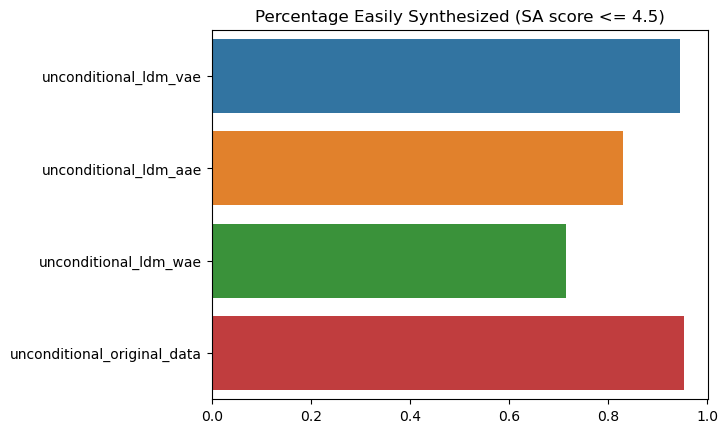

In [25]:
pct_easily_syn_non_conditioned = collections.OrderedDict(sorted(pct_easily_syn_non_conditioned.items(), key = lambda x: x[0].split('_')[1]))

sns.barplot(
    y = list(pct_easily_syn_non_conditioned.keys()), 
    x = list(pct_easily_syn_non_conditioned.values()), 
    orient = 'h'
)
plt.title('Percentage Easily Synthesized (SA score <= 4.5)')

In [26]:
avg_qed_non_conditioned = {}
for dist_type in guac_saqed['dist_type'].unique():
    qed_guac = guac_saqed[guac_saqed['dist_type'] == dist_type]['qed_scores'].to_list()
    avg_qed_non_conditioned[f'unconditional_{dist_type}'] =sum(qed_guac)/len(qed_guac)

Text(0.5, 1.0, 'Average QED')

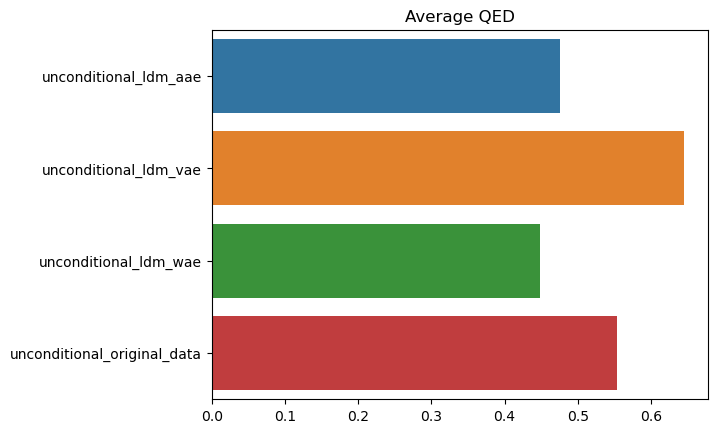

In [27]:
avg_qed_non_conditioned = collections.OrderedDict(sorted(avg_qed_non_conditioned.items()))#, key = lambda x: x[0].split('_')[1]))

sns.barplot(
    y = list(avg_qed_non_conditioned.keys()), 
    x = list(avg_qed_non_conditioned.values()), 
    orient = 'h'
)
plt.title('Average QED')

# L1000 conditional generation

In [2]:
with open("cond_generation_res/ldm_con_vae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_vae_data = pickle.load(f)
    
with open("cond_generation_res/ldm_con_aae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_aae_data = pickle.load(f)
    
with open("cond_generation_res/ldm_con_wae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_wae_data = pickle.load(f)
    
with open('/data/conghao001/FYP/drug_discovery/BiAAE/cond_generation_res/biaae_generated_molecules_and_sa_scores.pkl', 'rb') as f:
    biaae_data = pickle.load(f)

In [3]:
print(len(ldm_vae_data))
print(len(ldm_aae_data))
print(len(ldm_wae_data))
print(len(biaae_data))

356
356
356
449


In [4]:
# tmp_aae = {}
# for key in tqdm(ldm_aae_data):
#     if 'sa_scores' not in ldm_aae_data[key].keys():
#         continue
#     else:
#         tmp_aae[key] = ldm_aae_data[key]

# print(len(tmp_aae))
# ldm_aae_data = tmp_aae

In [5]:
keys = [k for k in ldm_vae_data.keys() if k in biaae_data.keys()]
len(keys)

356

In [6]:
ldm_vae_data = {k:ldm_vae_data[k] for k in keys}
ldm_aae_data = {k:ldm_aae_data[k] for k in keys}
ldm_wae_data = {k:ldm_wae_data[k] for k in keys}
biaae_data = {k:biaae_data[k] for k in keys}

print(len(ldm_vae_data), len(ldm_aae_data), len(ldm_wae_data), len(biaae_data))

356 356 356 356


In [7]:
# def extract_mols(data):
#     tmp = []
#     for test_set_smile in data:
#         smiles = data[test_set_smile]["generated_smiles"]
#         smiles = [smile for smile in smiles if '.' not in smile]

#         remove_dup_smiles = list(set(smiles))
#         mols = [Chem.MolFromSmiles(smile) for smile in remove_dup_smiles]
#         tmp += mols
#     return tmp

In [7]:
original_l100_df = pd.read_csv('/data/ongh0068/l1000/l1000_biaae/lincs/experiments_filtered.csv')
original_l100_df

,Unnamed: 0,CellLine,Time,Dose,ControlIndices,TumourIndices,SMILES,DrugIndex_maccs,DrugIndex_pharmacophore2d720,DrugIndex_morgan,...,primary_site_large intestine,primary_site_liver,primary_site_lung,primary_site_muscle,primary_site_ovary,primary_site_prostate,primary_site_skin,primary_site_stomach,primary_site_unknown,original_idx
0,0,A375,6.0,10.00,12373 12374 12375 12376 12377 12378 12379 1238...,343818 343819 343820,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,0,0,0,0,1,0,0,0
1,1,A549,6.0,10.00,12471 12472 12473 12474 12475 12476 12477 1247...,346328 346329,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,1,0,0,0,0,0,0,1
2,2,A549,24.0,10.00,12529 12530 12531 12532 12533 12534 12535 1253...,349439 349440 349441,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,1,0,0,0,0,0,0,2
3,3,ASC,24.0,10.00,12626 12627 12628 12629 12630 12631 12632 1263...,352969 352970 352971 352972,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,0,0,0,0,0,0,0,3
4,4,HA1E,6.0,10.00,3875 3876 3877 3878 3879 3880 3881 3882 3883 3...,82857 82858,CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1,6172,1394,918,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99309,187037,VCAP,24.0,4.96,17239 17240 17241 17242 17243 17244 17245 1724...,475303 475304 475305,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NC(C)c3ccccc3)...,6652,3995,8878,...,0,0,0,0,0,1,0,0,0,99309
99310,187038,VCAP,6.0,5.01,18703 18704 18705 18706 18707 18708 18709 1871...,467715 467716 467717,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...,6668,3869,872,...,0,0,0,0,0,1,0,0,0,99310
99311,187039,VCAP,24.0,5.01,17239 17240 17241 17242 17243 17244 17245 1724...,475309 475310 475311,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...,6668,3869,872,...,0,0,0,0,0,1,0,0,0,99311
99312,187040,VCAP,6.0,5.04,18703 18704 18705 18706 18707 18708 18709 1871...,467720 467721 467722,CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCC)N(Cc3ccccc...,535,6817,8409,...,0,0,0,0,0,1,0,0,0,99312


In [8]:
original_smiles = original_l100_df.SMILES.unique().tolist()
len(original_smiles)

5216

In [9]:
def extract_smiles(data):
    tmp = []
    for test_set_smile in data:
        tmp += data[test_set_smile]["generated_smiles"]
    return tmp


l1000_smiles = {
    "ldm_vae": extract_smiles(ldm_vae_data),
    "ldm_aae": extract_smiles(ldm_aae_data),
    "ldm_wae": extract_smiles(ldm_wae_data),
    "GLDM (Ours)": extract_smiles(ldm_aae_data),
    "BiAAE": extract_smiles(biaae_data),
    "Original Data": original_smiles
}

In [10]:
# l1000_smiles['ldm_vae'] = np.random.choice(l1000_smiles['ldm_vae'], len(original_smiles)).tolist()
# l1000_smiles['ldm_aae'] = np.random.choice(l1000_smiles['ldm_aae'], len(original_smiles)).tolist()
# l1000_smiles['ldm_wae'] = np.random.choice(l1000_smiles['ldm_wae'], len(original_smiles)).tolist()

# l1000_smiles['GLDM (Ours)'] = np.random.choice(l1000_smiles['GLDM (Ours)'], len(original_smiles)).tolist()
# l1000_smiles['BiAAE'] = np.random.choice(l1000_smiles['BiAAE'], len(original_smiles)).tolist()

# l1000_smiles['original_data'] = np.random.choice(l1000_smiles['original_data'], len(ldm_vae_data)).tolist()

In [11]:
l1000_smiles

{'ldm_vae': ['N',
  'C',
  'NC1=CC=CC=C1F',
  'N#CC1=CC=C(F)C=C1',
  'COC1=CC=C(F)C=C1',
  'N#CC1=CC=CC(Cl)=C1',
  'N#CCC1=CNC2=CC=CC=C12',
  'CC(N)CO',
  'CC(N)CO',
  'N#CC1=CC=C(N)C=C1Br',
  'COC1=CC=C(CN2CCCCC2)C=C1',
  'O=S(=O)(O)NNC1=CC=CC=C1Cl',
  'CN(C)CCCO',
  'O=CCSC1=NN=CO1',
  'CCOC1=C(Cl)C=CC=C1F',
  'COC1=CC=C(C(N)=O)C=C1',
  'COC1=CC=C(C#N)C=C1Br',
  'NCCNC1=CC=C(F)C=C1',
  'NNN=CC1=CC=C(F)C=C1',
  'CCC(=O)NC(C)C',
  'CC(N)C(=O)N1CCN(C)CC1',
  'CNN=CC1=CC=C(Br)C=C1O',
  'O=C(CCl)NC1=CC=CC=C1F',
  'O=C(CCl)NC1=CC=C(F)C=C1',
  'CCN(C)CC1=CC=CC=C1F',
  'CC(N)C=CC1=CC=C(O)C=C1',
  'CSCC(=O)C1=CC=C(F)C=C1',
  'O=C(O)C(CN1CCCC1)C1=CC=CC=C1',
  'CC1=C(C)C(C(=O)C2=CC=C(F)C=C2)=NO1',
  'CC(CC1=CC=C(Cl)C=C1)NC(=O)C1=CN=C2C=CC=CC2=C1',
  'CN(C)CC(=O)NCC1=CC=CC(Cl)=C1',
  'CN(C)C(=O)CC1=CC=CC=C1',
  'CCS(=O)(=O)OC1=CC=CC=C1',
  'COC(=O)C1CNC(C)C1',
  'CC(C)CNC1=CC=C(O)C(F)=C1',
  'CCN(C)C(=O)C1=CC=C(Cl)C=C1',
  'CCNCCOC1=CC=CC=C1F',
  'CCC(=O)NCC1=CC=C(Cl)C=C1',
  'CCNC(=O)C1=CC=C(O)

In [14]:
dfs = []
for key in l1000_smiles.keys():
    
    
    mols = [Chem.MolFromSmiles(smile) for smile in l1000_smiles[key]]
    print(len(mols))
    qed_scores = [qed(mol) for mol in mols]
    sa_scores, pct_easily_synthesized = compute_sa_score(mols)
    
    dist_type = [key for _ in range(len(l1000_smiles[key]))]
    
    df = pd.DataFrame([sa_scores, qed_scores, dist_type]).T
    df.columns = ['sa_score', 'qed_scores', 'dist_type']
    dfs.append(df)

35600
35600
35600
35600
23240
5216


In [24]:
df_l1000_scores = pd.concat(dfs)
df_l1000_scores

,sa_score,qed_scores,dist_type
0,6.667815,0.397555,ldm_vae
1,7.328415,0.359785,ldm_vae
2,1.521449,0.503068,ldm_vae
3,1.518963,0.512061,ldm_vae
4,1.063347,0.557432,ldm_vae
...,...,...,...
5211,4.64607,0.776539,Original Data
5212,4.706874,0.779668,Original Data
5213,4.727672,0.80455,Original Data
5214,3.983328,0.74367,Original Data


In [25]:
# df_l1000_scores.to_csv('cond_generation_res/SA_QED_scores.csv', header=True, index=None)
df_l1000_scores = pd.read_csv('cond_generation_res/SA_QED_scores.csv', header=0)
df_l1000_scores

,sa_score,qed_scores,dist_type
0,6.667815,0.397555,ldm_vae
1,7.328415,0.359785,ldm_vae
2,1.521449,0.503068,ldm_vae
3,1.518963,0.512061,ldm_vae
4,1.063347,0.557432,ldm_vae
...,...,...,...
170851,4.646070,0.776539,Original Data
170852,4.706874,0.779668,Original Data
170853,4.727672,0.804550,Original Data
170854,3.983328,0.743670,Original Data


Text(0.5, 1.0, 'Conditioned on gene expression SA')

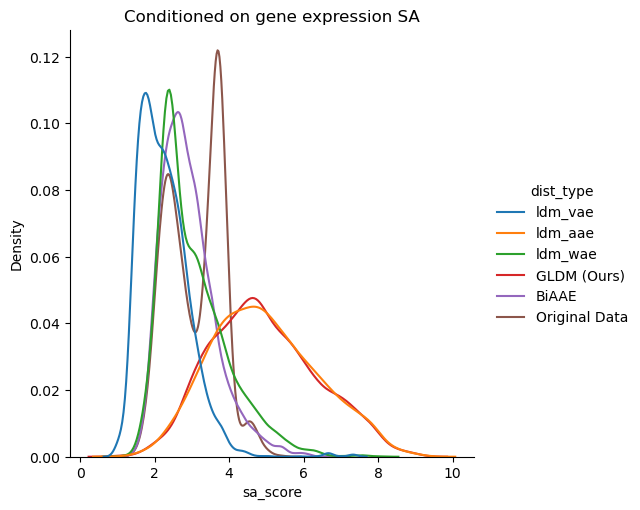

In [34]:
sns.displot(df_l1000_scores ,x = 'sa_score',  hue="dist_type", kind = 'kde')
plt.title('Conditioned on gene expression SA')

Text(0.5, 1.0, 'Conditioned on gene expression QED')

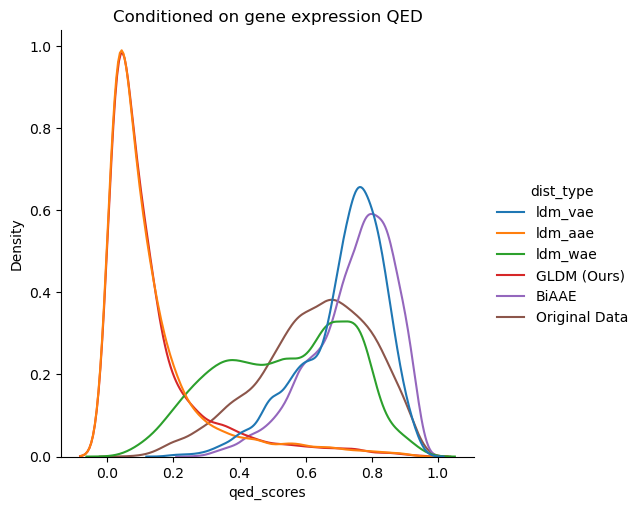

In [35]:
sns.displot(df_l1000_scores ,x = 'qed_scores',  hue="dist_type", kind = 'kde')
plt.title('Conditioned on gene expression QED') 

In [26]:
pct_easily_syn = {}
for dist_type in df_l1000_scores['dist_type'].unique():
    sa_scores = df_l1000_scores[df_l1000_scores['dist_type'] == dist_type]['sa_score'].to_list()
    pct_easily_syn[dist_type] = len([score for score in sa_scores if score<=4.5])/len(sa_scores)

In [27]:
for key in [key for key in list(pct_easily_syn.keys()) if 'original' not in key]:
    if 'original' not in pct_easily_syn:
        pct_easily_syn[f'conditional_{key}'] = pct_easily_syn.pop(key)

Text(0.5, 1.0, 'Percentage Easily Synthesized (SA score <= 4.5)')

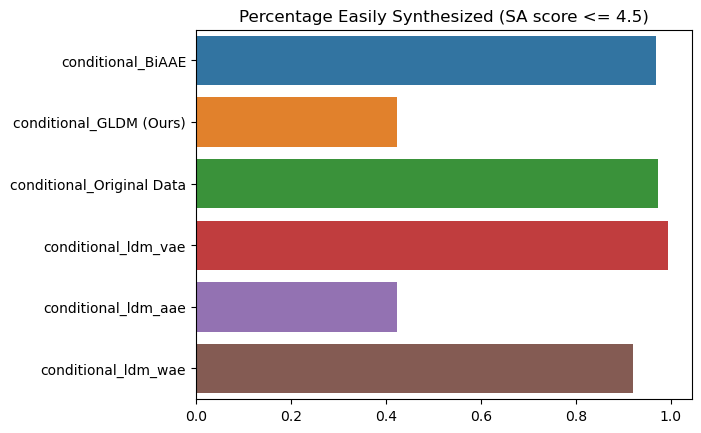

In [28]:
pct_easily_syn = collections.OrderedDict(sorted(pct_easily_syn.items(), key = lambda x: x[0].split('_')[1]))

sns.barplot(
    y = list(pct_easily_syn.keys()), 
    x = list(pct_easily_syn.values()), 
    orient = 'h'
)
plt.title('Percentage Easily Synthesized (SA score <= 4.5)')

In [29]:
avg_qed_conditioned = {}
for dist_type in df_l1000_scores['dist_type'].unique():
    qed_score = df_l1000_scores[df_l1000_scores['dist_type'] == dist_type]['qed_scores'].to_list()
    avg_qed_conditioned[f'conditional_{dist_type}'] = sum(qed_score)/len(qed_score)

Text(0.5, 1.0, 'Average QED')

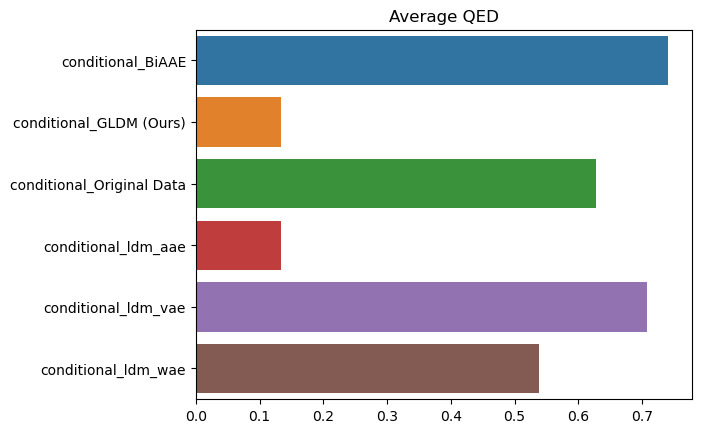

In [30]:
avg_qed_conditioned = collections.OrderedDict(sorted(avg_qed_conditioned.items()))#, key = lambda x: x[0].split('_')[1]))

sns.barplot(
    y = list(avg_qed_conditioned.keys()), 
    x = list(avg_qed_conditioned.values()), 
    orient = 'h'
)
plt.title('Average QED')

In [42]:
pct_easily_syn_conditioned_vs_not = {
    **pct_easily_syn, **pct_easily_syn_non_conditioned
}
pct_easily_syn_conditioned_vs_not

NameError: name 'pct_easily_syn_non_conditioned' is not defined

In [45]:
pct_easily_syn_conditioned_vs_not['original_guacamol_data'] = pct_easily_syn_conditioned_vs_not.pop('unconditional_original_data')
pct_easily_syn_conditioned_vs_not['original_l1000_data'] = pct_easily_syn_conditioned_vs_not.pop('original_data')
pct_easily_syn_conditioned_vs_not

{'conditional_ldm_vae': 0.9934815950920245,
 'conditional_ldm_aae': 0.9940567484662577,
 'conditional_ldm_wae': 0.4461273006134969,
 'unconditional_ldm_vae': 0.9451,
 'unconditional_ldm_aae': 0.8288,
 'unconditional_ldm_wae': 0.7149,
 'original_guacamol_data': 0.953,
 'original_l1000_data': 0.9737346625766872}

In [46]:
aae_sa = {
    'conditional_LDM': pct_easily_syn_conditioned_vs_not['conditional_ldm_aae'],
    'unconditional_LDM': pct_easily_syn_conditioned_vs_not['unconditional_ldm_aae'],
    'original_guacamol_data': pct_easily_syn_conditioned_vs_not['original_guacamol_data'],
    'original_l1000_data': pct_easily_syn_conditioned_vs_not['original_l1000_data']
}
aae_sa

{'conditional_LDM': 0.9940567484662577,
 'unconditional_LDM': 0.8288,
 'original_guacamol_data': 0.953,
 'original_l1000_data': 0.9737346625766872}

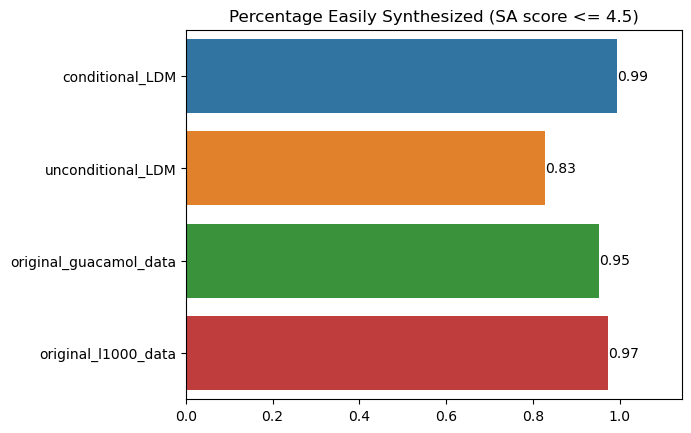

In [49]:
# ax = sns.barplot(
#     y = list(pct_easily_syn_conditioned_vs_not.keys()), 
#     x = list(pct_easily_syn_conditioned_vs_not.values()), 
#     orient = 'h'
# )

ax = sns.barplot(
    y = list(aae_sa.keys()), 
    x = list(aae_sa.values()), 
    orient = 'h'
)
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.margins(x=0.15)
plt.title('Percentage Easily Synthesized (SA score <= 4.5)')

# plt.savefig('../plots/sa/SA.png', bbox_inches='tight')
plt.savefig('../plots/sa/SA_aae.png', bbox_inches='tight')

In [50]:
avg_qed_conditioned_vs_not = {
    **avg_qed_conditioned, **avg_qed_non_conditioned
}

In [51]:
avg_qed_conditioned_vs_not['original_guacamol_data'] = avg_qed_conditioned_vs_not.pop('unconditional_original_data')
avg_qed_conditioned_vs_not['original_l1000_data'] = avg_qed_conditioned_vs_not.pop('conditional_original_data')
avg_qed_conditioned_vs_not

{'conditional_ldm_aae': 0.7095930699081374,
 'conditional_ldm_vae': 0.7114201878468814,
 'conditional_ldm_wae': 0.1538736141296655,
 'unconditional_ldm_aae': 0.47626151338015604,
 'unconditional_ldm_vae': 0.6453311068749353,
 'unconditional_ldm_wae': 0.4483085379106169,
 'original_guacamol_data': 0.5534026905584383,
 'original_l1000_data': 0.627399655968396}

In [52]:
aae_qed = {
    'conditional_LDM': avg_qed_conditioned_vs_not['conditional_ldm_aae'],
    'unconditional_LDM': avg_qed_conditioned_vs_not['unconditional_ldm_aae'],
    'original_guacamol_data': avg_qed_conditioned_vs_not['original_guacamol_data'],
    'original_l1000_data': avg_qed_conditioned_vs_not['original_l1000_data']
}
aae_qed

{'conditional_LDM': 0.7095930699081374,
 'unconditional_LDM': 0.47626151338015604,
 'original_guacamol_data': 0.5534026905584383,
 'original_l1000_data': 0.627399655968396}

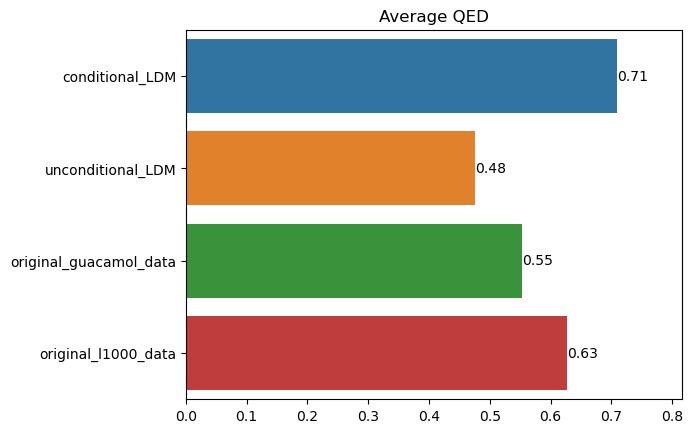

In [53]:
# ax1 = sns.barplot(
#     y = list(avg_qed_conditioned_vs_not.keys()), 
#     x = list(avg_qed_conditioned_vs_not.values()), 
#     orient = 'h'
# )

ax1 = sns.barplot(
    y = list(aae_qed.keys()), 
    x = list(aae_qed.values()), 
    orient = 'h'
)
ax1.bar_label(ax1.containers[0], fmt='%.2f')
ax1.margins(x=0.15)
plt.title('Average QED')

# plt.savefig('../plots/qed/QED.png', bbox_inches='tight')
plt.savefig('../plots/qed/QED_aae.png', bbox_inches='tight')